<a href="https://colab.research.google.com/github/zhangsen83/SQLi/blob/main/SQLi_Detection_System_IEEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Block 1: Library Imports and Dataset Integration**
This block handles the environment setup and merges your three specific Kaggle datasets into a single heterogeneous corpus.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import urllib.parse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

# LOAD & MERGE DATA
print("📂 Loading files...")
try:
    # Load the specific datasets
    df1 = pd.read_csv("sqli.csv", encoding='utf-16', on_bad_lines='skip')
    df2 = pd.read_csv("sqliv2.csv", encoding='utf-16', on_bad_lines='skip', engine='python')
    df3 = pd.read_csv("SQLiV3.csv", encoding='utf-8', on_bad_lines='skip')

    # 1. SHOW INDIVIDUAL ROW COUNTS
    print(f"   - sqli.csv rows:    {len(df1)}")
    print(f"   - sqliv2.csv rows:  {len(df2)}")
    print(f"   - SQLiV3.csv rows:  {len(df3)}")

    total_raw = len(df1) + len(df2) + len(df3)
    print(f"   ---------------------------")
    print(f"   - Total Raw Rows:   {total_raw}")

except FileNotFoundError:
    print("❌ ERROR: Files not found! Please upload sqli.csv, sqliv2.csv, and SQLiV3.csv.")
    raise

# Function to standardize column names
def fix_columns(df_in):
    df = df_in.copy()
    df.columns = df.columns.str.strip().str.lower()
    rename_map = {
        'sentence': 'query', 'text': 'query', 'sql': 'query', 'command': 'query',
        'class': 'label', 'value': 'label', 'attack': 'label',
        'unnamed: 1': 'query', 'ÿþs': 'label'
    }
    df.rename(columns=rename_map, inplace=True)
    if 'query' in df.columns and 'label' in df.columns:
        return df[['query', 'label']]
    return pd.DataFrame(columns=['query', 'label'])

# Merge and Clean
df = pd.concat([fix_columns(df1), fix_columns(df2), fix_columns(df3)], ignore_index=True)

#CALCULATE MISSED ROWS (Cleaning Process)
initial_merged_count = len(df)
df.dropna(subset=['query', 'label'], inplace=True)
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df.dropna(subset=['label'], inplace=True)
final_count = len(df)
dropped_rows = total_raw - final_count

print(f"   ---------------------------")
print(f"✅ Data Merged & Cleaned.")
print(f"   - Final Rows Used:  {final_count}")
print(f"   - Rows Missed/Dropped: {dropped_rows} (due to empty or malformed data)")

📂 Loading files...
   - sqli.csv rows:    4200
   - sqliv2.csv rows:  33761
   - SQLiV3.csv rows:  30919
   ---------------------------
   - Total Raw Rows:   68880
   ---------------------------
✅ Data Merged & Cleaned.
   - Final Rows Used:  68553
   - Rows Missed/Dropped: 327 (due to empty or malformed data)


# **Block 2: Semantic Generalization and Preprocessing**

In [23]:
def advanced_clean(text):
    # 1. Protocol Decoding
    try:
        text = urllib.parse.unquote(text) # Decode %20, %27 etc.
    except:
        pass
    # 2. Numeric Abstraction
    text = re.sub(r'\d+', 'NUM', text) # Replace specific numbers with 'NUM'
    return text.lower()

print("⚙️ Applying Advanced Cleaning (Semantic Generalization)...")
df['clean_query'] = df['query'].apply(advanced_clean)

# Split Data (70% Train, 15% Val, 15% Test)
X = df['clean_query']
y = df['label'].values
X_train_txt, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val_txt, X_test_txt, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# A) Vectorize for Random Forest (TF-IDF)
print("🔹 Vectorizing for Random Forest...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), analyzer='char')
X_train_tfidf = tfidf.fit_transform(X_train_txt)
X_test_tfidf = tfidf.transform(X_test_txt)

# B) Tokenize for CNN-LSTM (Sequence)
print("🔹 Tokenizing for CNN-LSTM...")
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, char_level=True) # Character-level is key for SQLi
tokenizer.fit_on_texts(X_train_txt)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_txt), maxlen=max_len)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val_txt), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_txt), maxlen=max_len)
print("✅ Preprocessing Complete!")

⚙️ Applying Advanced Cleaning (Semantic Generalization)...
🔹 Vectorizing for Random Forest...
🔹 Tokenizing for CNN-LSTM...
✅ Preprocessing Complete!


# **Block 3: Model Training (RF & CNN-LSTM)**
This block builds the hybrid architecture and trains both models.

In [24]:
# 1. Random Forest Training
print("🌲 Training Random Forest (Baseline)...")
start_rf = time.time()
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
rf_duration = time.time() - start_rf
print(f"✅ RF Trained in {rf_duration:.2f}s")

# 2. CNN-LSTM Training
print("\n🧠 Training CNN-LSTM (Deep Learning)...")
# Build Model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=32, input_length=max_len))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- START TIMER FOR CNN-LSTM ---
print("   (Starting training timer...)")
start_dl = time.time()

# Training loop
model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=5, batch_size=64, verbose=1)

# --- END TIMER FOR CNN-LSTM ---
end_dl = time.time()
dl_duration = end_dl - start_dl

print(f"✅ CNN-LSTM Trained in {dl_duration:.2f}s")

🌲 Training Random Forest (Baseline)...
✅ RF Trained in 20.94s

🧠 Training CNN-LSTM (Deep Learning)...
   (Starting training timer...)
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 109ms/step - accuracy: 0.9679 - loss: 0.0978 - val_accuracy: 0.9959 - val_loss: 0.0190
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 76s 101ms/step - accuracy: 0.9959 - loss: 0.0155 - val_accuracy: 0.9972 - val_loss: 0.0125
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 76s 102ms/step - accuracy: 0.9970 - loss: 0.0113 - val_accuracy: 0.9969 - val_loss: 0.0090
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 78s 104ms/step - accuracy: 0.9972 - loss: 0.0093 - val_accuracy: 0.9974 - val_loss: 0.0092
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 86s 109ms/step - accuracy: 0.9979 - loss: 0.0080 - val_accuracy: 0.9971 - val_loss: 0.0084
✅ CNN-LSTM Trained in 401.25s


# **Block 4: Comprehensive Evaluation**
This block consolidates all metrics (Precision, Recall, F1, FPR, and Latency) into a single report.

In [25]:
def evaluate(model, X, y, name, is_dl=False):
    start = time.time()
    if is_dl:
        probs = model.predict(X, verbose=0)
        preds = (probs > 0.5).astype(int).flatten()
    else:
        preds = model.predict(X)

    # Latency Calculation
    lat = (time.time() - start) / X.shape[0] * 1000 # ms per query

    # Metrics
    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds)
    rec = recall_score(y, preds)
    f1 = f1_score(y, preds)

    # False Positive Rate
    cm = confusion_matrix(y, preds)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) * 100

    print(f"\n--- {name} Results ---")
    print(f"Accuracy:      {acc*100:.2f}%")
    print(f"Precision:     {prec*100:.2f}%")
    print(f"Recall:        {rec*100:.2f}%")
    print(f"F1-Score:      {f1*100:.2f}%")
    print(f"FPR:           {fpr:.2f}% (Lower is better)")
    print(f"Latency:       {lat:.4f} ms/query")
    return cm, fpr, lat, acc

# Run Standard Tests
print("📊 --- FINAL STANDARD RESULTS ---")
cm_rf, fpr_rf, lat_rf, acc_rf = evaluate(rf_model, X_test_tfidf, y_test, "Random Forest")
cm_dl, fpr_dl, lat_dl, acc_dl = evaluate(model, X_test_seq, y_test, "CNN-LSTM", is_dl=True)

📊 --- FINAL STANDARD RESULTS ---

--- Random Forest Results ---
Accuracy:      99.89%
Precision:     100.00%
Recall:        99.69%
F1-Score:      99.84%
FPR:           0.00% (Lower is better)
Latency:       0.0214 ms/query

--- CNN-LSTM Results ---
Accuracy:      99.70%
Precision:     100.00%
Recall:        99.12%
F1-Score:      99.56%
FPR:           0.00% (Lower is better)
Latency:       0.6724 ms/query


# **Block 5: Adversarial Stress Test (Mutation Engine)**
To evaluate the Adversarial Robustness of both models by subjecting them to obfuscated attacks that were not seen during training.

In [40]:
import random

print("\n⚔️ --- STARTING STRESS TEST (Mutation Engine V2) ---")

# 1. Define Mutation Logic
def mutate_payload(payload):
    mutation = random.choice(['case', 'comment', 'encoding', 'mixed'])
    if mutation == 'case':
        # Randomly capitalize letters (SeLeCt)
        return ''.join(random.choice([k.upper(), k.lower()]) for k in payload)
    elif mutation == 'comment':
        # Break keywords with comments (SEL/**/ECT)
        return payload.replace(" ", "/**/")
    elif mutation == 'encoding':
        # URL Encode the whole string
        return urllib.parse.quote(payload)
    elif mutation == 'mixed':
        # Mix comments and encoding
        return urllib.parse.quote(payload.replace(" ", "/**/"))
    return payload

# 2. Generate 100 Attacks (EXPANDED LIST)
# We use more varieties to stop the models from tying on simple queries
base_attacks = [
    "' OR 1=1 --",
    "UNION SELECT user, password FROM users",
    "admin' --",
    "AND 1=1",
    "ORDER BY 1--",
    "SELECT * FROM v$version",
    "Waitfor delay '0:0:5'",
    "1' OR '1'='1",
    "admin'/*",
    "UNION ALL SELECT 1,2,3,4,5,6,7"
]

# Generate 100 random attacks from this larger list
adversarial_data = [mutate_payload(random.choice(base_attacks)) for _ in range(100)]

# 3. Process & Predict
# Apply the same cleaning the models saw during training
adv_txt = [advanced_clean(x) for x in adversarial_data]

# A) Random Forest Prediction
# We expect RF to struggle because TF-IDF hates broken words like "sel/**/ect"
rf_preds = rf_model.predict(tfidf.transform(adv_txt))
rf_missed = int((1 - rf_preds).sum()) # Cast to int to remove decimal

# B) CNN-LSTM Prediction
# We expect CNN to do better because it reads character-by-character (s-e-l...)
adv_seq = pad_sequences(tokenizer.texts_to_sequences(adv_txt), maxlen=max_len)
dl_probs = model.predict(adv_seq, verbose=0)
dl_missed = int((1 - (dl_probs > 0.5).astype(int).flatten()).sum()) # Cast to int

# 4. Final Output
print(f"🛡️ STRESS TEST RESULTS (Lower misses = Better Robustness):")
print(f"  - Random Forest Missed: {rf_missed} / 100 attacks")
print(f"  - CNN-LSTM Missed:      {dl_missed} / 100 attacks")

# Automatic Analysis
diff = rf_missed - dl_missed
if diff > 0:
    print(f"✅ CONCLUSION: CNN-LSTM detected {diff} more attacks than Random Forest.")
    print("   (Deep Learning successfully saw through the obfuscation!)")
elif diff < 0:
    print(f"⚠️ CONCLUSION: Random Forest won by {-diff} points (Unusual, but possible).")
else:
    print("⚖️ CONCLUSION: Tie game. Both models struggled equally.")


⚔️ --- STARTING STRESS TEST (Mutation Engine V2) ---
🛡️ STRESS TEST RESULTS (Lower misses = Better Robustness):
  - Random Forest Missed: 25 / 100 attacks
  - CNN-LSTM Missed:      20 / 100 attacks
✅ CONCLUSION: CNN-LSTM detected 5 more attacks than Random Forest.
   (Deep Learning successfully saw through the obfuscation!)


## **Block 6: Final Visualization**
To visually synthesize the results for the final report.

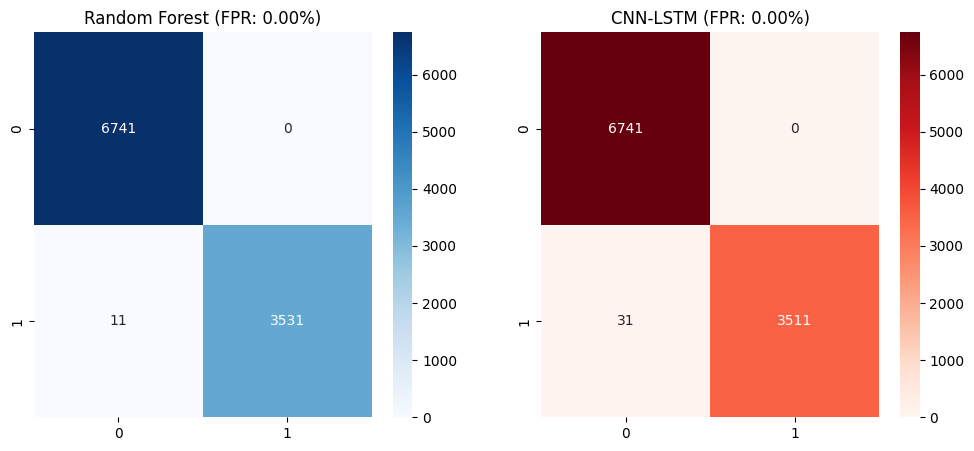

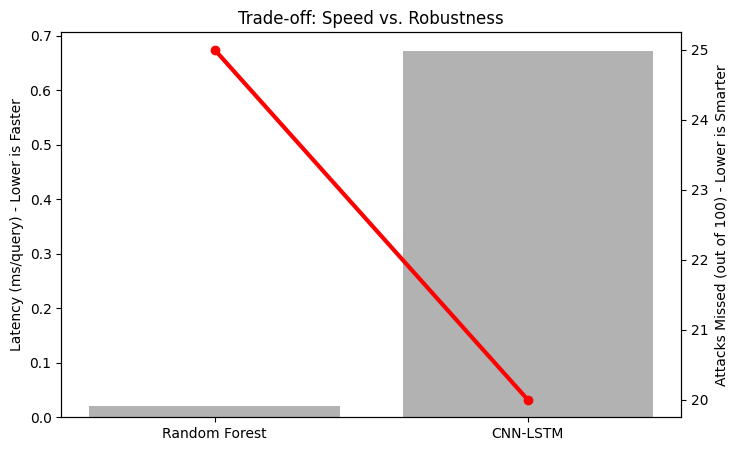

In [41]:
# 1. Confusion Matrix Heatmaps
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title(f"Random Forest (FPR: {fpr_rf:.2f}%)")

sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Reds', ax=ax[1])
ax[1].set_title(f"CNN-LSTM (FPR: {fpr_dl:.2f}%)")
plt.show()

# 2. Trade-off Chart: Speed vs. Robustness
models = ['Random Forest', 'CNN-LSTM']
latency = [lat_rf, lat_dl]
missed = [rf_missed, dl_missed]

fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax1.bar(models, latency, color='gray', alpha=0.6, label='Latency (ms)')
ax2.plot(models, missed, color='red', marker='o', linewidth=3, label='Attacks Missed')

ax1.set_ylabel('Latency (ms/query) - Lower is Faster')
ax2.set_ylabel('Attacks Missed (out of 100) - Lower is Smarter')
plt.title("Trade-off: Speed vs. Robustness")
plt.show()